# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, I will identify lane line on the road.

I will use domain driven development for this task to make code cleaner and easier to write, debug and read.


## Preliminary ideas to define a domain model

The challenge is to detect lanes on images or videos.

An image can have different sizes.

Video is a sequence of images approximately 25 images per second.

One left line and one right line bound one lane on an image.

Coordinates ((x1, y1), (x2, y2)) specify one line, but since images can come in different sizes, I will normalize x and y to 0..1 range.

To make a lane detection pipeline, I will use the sequence of algorithms with a bunch of parameters.
**I expect the number of parameter combinations to grow enormously. 
If I spend 1 minute checking every combination, it will take years to complete.
I need an automated algorithm to check pipeline quality.**
I will take every test image and one image per second for every test video and label it manually in "Supervise.ly." I will write an automatic algorithm to calculate lane detection pipeline quality.

Then I will run **Monte Carlo** simulation of algorithm for millions times with random parameters to find out which parameters produce best quality.

I believe the lane detection pipeline for video should use  **averaging technique** for last five frames since the car cannot move far away in 0.2 sec (5 frames).

# Base classes

In [1]:
import math

class Point:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
    def distance_to(self, point) -> float:
        return ((self.x - point.x) ** 2 + (self.y - point.y) ** 2) ** 0.5
        
    def __str__(self):
        return "({:.2f}:{:.2f})".format(self.x, self.y)

class Line:
    def __init__(self, point_1, point_2):
        self.point_1 = point_1
        self.point_2 = point_2
        
        if point_1.x != point_2.x:
            self.m = (point_1.y - point_2.y) / (point_1.x - point_2.x)
            self.b = point_2.y - self.m * point_2.x
        else:
            self.m = float('+inf')
            self.b = point_1.x
    
    def dissimilarity_with(self, other_line):
        angle = math.degrees(math.atan(self.m))
        other_line_angle = math.degrees(math.atan(other_line.m))
        return ((angle / 90 - other_line_angle / 90) ** 2 + (self.b - other_line.b) ** 2) ** 0.5
    
    def length(self):
        return self.point_1.distance_to(point=self.point_2)
    
    def __str__(self):
        return "{}-{}".format(self.point_1, self.point_2)
    
    def find_intersection_point_with(self, other_line):
        intersection_x = (other_line.b - self.b) / (self.m - other_line.m)
        intersection_y = self.m * (other_line.b - self.b) / (self.m - other_line.m) + self.b
        return Point(x=intersection_x, y=intersection_y)

class Lane:
    def __init__(self, left_line: Line, right_line: Line):
        self.left_line = left_line
        self.right_line = right_line
        
    def dissimilarity_with(self, other_lane):
        return self.left_line.dissimilarity_with(other_lane.left_line) + self.right_line.dissimilarity_with(other_lane.right_line)
    
    def get_full_length_left_line(self) -> Line:
        horizontal_line = Line(point_1=Point(x=0, y=1), point_2=Point(x=1, y=1))
        left_line_bottom_point = self.left_line.find_intersection_point_with(horizontal_line)
        left_and_right_intersection_point = self.left_line.find_intersection_point_with(right_line)
       
        return Line(point_1=left_line_bottom_point, point_2=left_and_right_intersection_point)
    
    def get_full_length_right_line(self) -> Line:
        horizontal_line = Line(point_1=Point(x=0, y=1), point_2=Point(x=1, y=1))
        right_line_bottom_point = self.right_line.find_intersection_point_with(horizontal_line)
        left_and_right_intersection_point = self.left_line.find_intersection_point_with(right_line)
       
        return Line(point_1=right_line_bottom_point, point_2=left_and_right_intersection_point)
            

In [2]:
point_1 = Point(x=0, y=0)
point_2 = Point(x=3, y=4)
print(point_1.distance_to(point=point_2))

5.0


In [3]:
line = Line(point_1=point_1, point_2=point_2)
print(line.length())

5.0


In [4]:
line = Line(point_1=Point(x=0, y=0), point_2=Point(x=1, y=1))
line_perpendicular_to_first = Line(point_1=Point(x=1, y=0), point_2=Point(x=0, y=1))
print(line.dissimilarity_with(line_perpendicular_to_first))

1.4142135623730951


In [5]:
same_line_as_first = Line(point_1=Point(x=0, y=0), point_2=Point(x=0.5, y=0.5))
print(line.dissimilarity_with(same_line_as_first))

0.0


In [6]:
another_variant_of_first_line = Line(point_1=Point(x=0.5, y=0.5), point_2=Point(x=1, y=1))
print(line.dissimilarity_with(another_variant_of_first_line))

0.0


In [7]:
vertical_line = Line(point_1=Point(x=0, y=0), point_2=Point(x=0, y=1))
print(line.dissimilarity_with(vertical_line))

0.5


In [8]:
slightly_different_line_than_first = Line(point_1=Point(x=0.1, y=0), point_2=Point(x=1, y=1))
print(line.dissimilarity_with(slightly_different_line_than_first))

0.11604431281396178


In [9]:
point = line.find_intersection_point_with(other_line=line_perpendicular_to_first)
print(point)

(0.50:0.50)


In [10]:
class LaneImage:
    def __init__(self, image, lane):
        self.image = image
        self.lane = lane
        
    def dissimilarity_with(other_lane_image):
        return self.lane.dissimilarity_with(other_lane_image)

# Making train dataset

To make train dataset I use images from test_images folder and every 25'th frame from test_videos folder then I mark left line and right line in "Supervise.ly" service by hand.

<img src="examples/supervisely.png">

**There are no validation nor test dataset since I believe model has so few parameters (eleven to be precise) that it cannot overfit on train data.**

# Load train dataset

In [11]:
import os
from PIL import Image
import json
import numpy as np

def load_line_from_object(obj, width, height) -> Line:
    x1, y1 = obj['points']['exterior'][0][0] / width, obj['points']['exterior'][0][1] / height
    x2, y2 = obj['points']['exterior'][1][0] / width, obj['points']['exterior'][1][1] / height
    
    # all lines are drawn from bottom to top
    invert_order_of_points = y1 < y2

    if invert_order_of_points:
        return Line(point_1=Point(x=x2, y=y2), point_2=Point(x=x1, y=y1))
    else:
        return Line(point_1=Point(x=x1, y=y1), point_2=Point(x=x2, y=y2))

def load_lane_from_annotation_file(file_name: str) -> Lane: 
    with open(file_name) as json_file:
        annotation = json.load(json_file)
        
        width = annotation['size']['width']
        height = annotation['size']['height']
        
        for line in annotation['objects']:
            if line['classTitle'] == 'Left lane': # oops "lane" instead of "line" in annotations
                left_line = load_line_from_object(obj=line, width=width, height=height)
            elif line['classTitle'] == 'Right lane':
                right_line = load_line_from_object(line, width=width, height=height)
    
    return Lane(left_line=left_line, right_line=right_line)

def load_sub_dataset(path: str) -> [LaneImage]:
    result = []
    
    img_path = os.path.join(path, "img")
    ann_path = os.path.join(path, "ann")
    
    for img_file_name in os.listdir(img_path):
        full_img_file_name = os.path.join(img_path, img_file_name)
        full_ann_file_name = os.path.join(ann_path, "{}.json".format(img_file_name))
        
        img = np.array(Image.open(full_img_file_name))
        
        lane = load_lane_from_annotation_file(file_name=full_ann_file_name)
        
        lane_image = LaneImage(image=img, lane=lane)
        
        result.append(lane_image)
        
    return result

def load_dataset(path: str) -> [LaneImage]:
    result = []
    
    for dir_entry in os.scandir(path):
        if dir_entry.is_dir():
            result = result + load_sub_dataset(path=dir_entry.path)
            
    return result

train_dataset = load_dataset('./train/')

train_dataset

# Calculate region of interest from training data points

In [12]:
additional_space_percentage = 0.05

left_bottom_x = min([lane_image.lane.left_line.point_1.x for lane_image in train_dataset]) * (1 - additional_space_percentage)
left_bottom_y = min(1, max([lane_image.lane.left_line.point_1.y for lane_image in train_dataset]) * (1 + additional_space_percentage))
left_top_x = min([lane_image.lane.left_line.point_2.x for lane_image in train_dataset]) * (1 - additional_space_percentage)
left_top_y = min([lane_image.lane.left_line.point_2.y for lane_image in train_dataset]) * (1 - additional_space_percentage)

right_top_x = min(1, max([lane_image.lane.right_line.point_2.x for lane_image in train_dataset]) * (1 + additional_space_percentage))
right_top_y = min([lane_image.lane.right_line.point_2.y for lane_image in train_dataset]) * (1 - additional_space_percentage)
right_bottom_x = min(1, max([lane_image.lane.right_line.point_1.x for lane_image in train_dataset]) * (1 + additional_space_percentage))
right_bottom_y = min(1, max([lane_image.lane.right_line.point_1.y for lane_image in train_dataset]) * (1 + additional_space_percentage))

left_bottom = Point(x=left_bottom_x, y=left_bottom_y)
left_top = Point(x=left_top_x, y=left_top_y)
right_top = Point(x=right_top_x, y=right_top_y)
right_bottom = Point(x=right_bottom_x, y=right_bottom_y)

In [13]:
def get_image():
    return train_dataset[7].image.copy()

Region of interest:  ['(0.11:1.00) ->', '(0.42:0.55) ->', '(0.61:0.55) ->', '(0.98:1.00) ->']


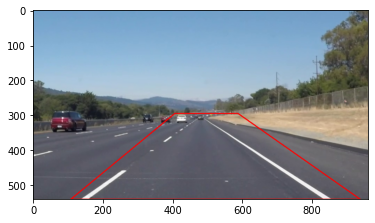

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import numpy as np

def draw_poly_line(image, points: [Point]):
    height = image.shape[0]
    width = image.shape[1]
    
    points_list = np.array([[int(point.x * width), int(point.y * height)] for point in points])
        
    cv2.polylines(image, [points_list], isClosed=True, color=[255, 0, 0], thickness=2) 
    
image = get_image()

region_of_interest = [
    left_bottom,
    left_top,
    right_top,
    right_bottom
]
draw_poly_line(image=image, points=region_of_interest)

plt.imshow(image)
print("Region of interest: ", ["{} ->".format(point) for point in region_of_interest])

# Build lane detection pipeline

In [15]:
def grayscale(image):    
    imgHSV = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    lChannel = imgHSV[:,:,2]
    return lChannel

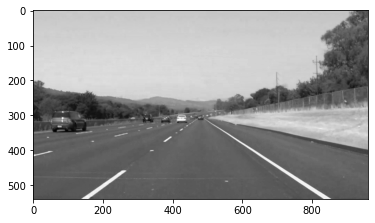

In [16]:
image = get_image()
image = grayscale(image=image)
plt.imshow(image, cmap='gray')

In [17]:
def blur_image(image, kernel_size):
    return cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)

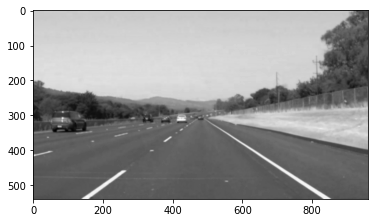

In [18]:
image = get_image()
grayscale_image = grayscale(image=image)
blurred_image = blur_image(image=grayscale_image, kernel_size=5)
plt.imshow(blurred_image, cmap='gray')

In [19]:
def clip_region_of_interest_on_grayscaled_image(grayscale_image, points: [Point]):
    mask = np.zeros_like(grayscale_image)   
    
    ignore_mask_color = 255
    
    height = grayscale_image.shape[0]
    width = grayscale_image.shape[1]
    
    points_list = np.array([[int(point.x * width), int(point.y * height)] for point in points])
        
    cv2.fillPoly(mask, [points_list], ignore_mask_color)

    masked_image = cv2.bitwise_and(grayscale_image, mask)
    return masked_image

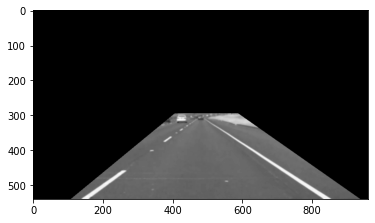

In [20]:
image = get_image()
grayscale_image = grayscale(image=image)
blurred_image = blur_image(image=grayscale_image, kernel_size=5)
clipped_image = clip_region_of_interest_on_grayscaled_image(grayscale_image=blurred_image, points=region_of_interest)
plt.imshow(clipped_image, cmap='gray')

In [21]:
def select_colors(image, low, high):
    mask = cv2.inRange(image, low, high)
    result = cv2.bitwise_and(image, image, mask=mask)
    return result

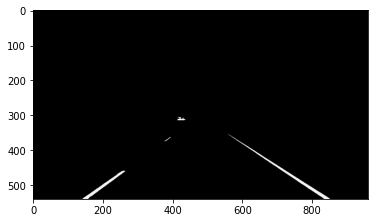

In [22]:
image = get_image()
grayscale_image = grayscale(image=image)
blurred_image = blur_image(image=grayscale_image, kernel_size=5)
clipped_image = clip_region_of_interest_on_grayscaled_image(grayscale_image=blurred_image, points=region_of_interest)
color_selected_image = select_colors(image=clipped_image, low=220, high=255)
plt.imshow(color_selected_image, cmap='gray')

In [23]:
def canny(image, low_threshold, high_threshold):
    return cv2.Canny(image, low_threshold, high_threshold)

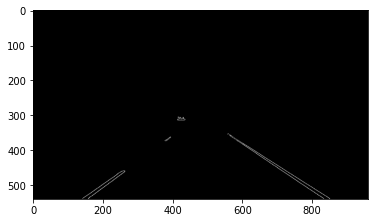

In [24]:
image = get_image()
grayscale_image = grayscale(image=image)
blurred_image = blur_image(image=grayscale_image, kernel_size=5)
clipped_image = clip_region_of_interest_on_grayscaled_image(grayscale_image=blurred_image, points=region_of_interest)
color_selected_image = select_colors(image=clipped_image, low=220, high=255)
canny_image = canny(color_selected_image, low_threshold=180, high_threshold=240)
plt.imshow(canny_image, cmap='gray')

In [25]:
def extract_left_and_right_line(image, rho, theta, threshold, min_line_len, max_line_gap) -> (Line, Line):
    lines = cv2.HoughLinesP(image, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)

    left_lines = []
    right_lines = []
    
    height = image.shape[0]
    width = image.shape[1]
    
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            
            point_1 = Point(x=x1 / width, y=y1 / height)
            point_2 = Point(x=x2 / width, y=y2 / height)
            
            line = Line(point_1=point_1, point_2=point_2)
            
            is_inclined_left = line.m < 0
            
            if is_inclined_left:
                left_lines.append(line)
            else:
                right_lines.append(line)

    longest_left_line = sorted(left_lines, key=lambda line: line.length(), reverse=True)[0] if left_lines else Line(point_1=Point(x=0, y=0), point_2=Point(x=0, y=0))
    longest_right_line = sorted(right_lines, key=lambda line: line.length(), reverse=True)[0] if right_lines else Line(point_1=Point(x=0, y=0), point_2=Point(x=0, y=0))
    
    return longest_left_line, longest_right_line

In [26]:
def draw_lines(image, lines: [Line]):
    height = image.shape[0]
    width = image.shape[1]
    
    for line in lines:
        x1 = int(line.point_1.x * width)
        y1 = int(line.point_1.y * height)
        x2 = int(line.point_2.x * width)
        y2 = int(line.point_2.y * height)
        cv2.line(image, (x1, y1), (x2, y2), color=[255, 0, 0], thickness=2) 

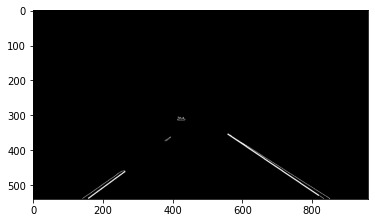

In [27]:
image = get_image()
grayscale_image = grayscale(image=image)
blurred_image = blur_image(image=grayscale_image, kernel_size=5)
clipped_image = clip_region_of_interest_on_grayscaled_image(grayscale_image=blurred_image, points=region_of_interest)
color_selected_image = select_colors(image=clipped_image, low=220, high=255)
canny_image = canny(color_selected_image, low_threshold=180, high_threshold=240)
left_line, right_line = extract_left_and_right_line(
    image=canny_image,
    rho=1,
    theta = np.pi/180,
    threshold=10,
    min_line_len=3,
    max_line_gap=5,
)
draw_lines(canny_image, [left_line, right_line])
plt.imshow(canny_image, cmap='gray')

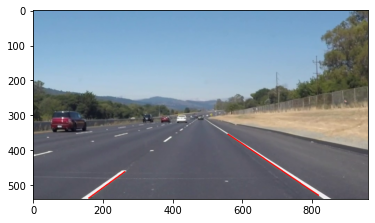

In [28]:
draw_lines(image, [left_line, right_line])
plt.imshow(image, cmap='gray')

In [29]:
class LaneDetector:
    def __init__(
        self,
        blur_kernel_size: int,
        region_of_interest: [Point],
        lo_color_threshold: int,
        hi_color_threshold: int,
        lo_canny_threshold: int,
        hi_canny_threshold: int,
        hough_rho: int,
        hough_theta: float,
        hough_threshold: int,
        min_line_len: int,
        max_line_gap: int
    ):
        self.blur_kernel_size: int = blur_kernel_size
        self.region_of_interest: [Point] = region_of_interest
        self.lo_color_threshold: int = lo_color_threshold
        self.hi_color_threshold: int = hi_color_threshold
        self.lo_canny_threshold: int = lo_canny_threshold
        self.hi_canny_threshold: int = hi_canny_threshold
        self.hough_rho: int = hough_rho
        self.hough_theta: float = hough_theta
        self.hough_threshold: int = hough_threshold
        self.min_line_len: int = min_line_len
        self.max_line_gap: int = max_line_gap
    
    def detect(self, image) -> Lane:
        grayscale_image = grayscale(image=image)
        blurred_image = blur_image(image=grayscale_image, kernel_size=self.blur_kernel_size)
        clipped_image = clip_region_of_interest_on_grayscaled_image(grayscale_image=blurred_image, points=region_of_interest)
        color_selected_image = select_colors(image=clipped_image, low=self.lo_color_threshold, high=self.hi_color_threshold)
        canny_image = canny(color_selected_image, low_threshold=self.lo_canny_threshold, high_threshold=self.hi_canny_threshold)
        left_line, right_line = extract_left_and_right_line(
            image=canny_image,
            rho=self.hough_rho,
            theta=self.hough_theta,
            threshold=self.hough_threshold,
            min_line_len=self.min_line_len,
            max_line_gap=self.max_line_gap,
        )
        
        lane = Lane(left_line=left_line, right_line=right_line)
        full_length_left_line = lane.get_full_length_left_line()
        full_length_right_line = lane.get_full_length_right_line()
        return Lane(left_line=full_length_left_line, right_line=full_length_right_line)
    
    def __str__(self):
        return """
        blur_kernel_size: {}
        region_of_interest: {}
        lo_color_threshold: {}
        hi_color_threshold: {}
        lo_canny_threshold: {}
        hi_canny_threshold: {}
        hough_rho: {}
        hough_theta: {}
        hough_threshold: {}
        min_line_len: {}
        max_line_gap: {}
""".format(
            self.blur_kernel_size,
            self.region_of_interest,
            self.lo_color_threshold,
            self.hi_color_threshold,
            self.lo_canny_threshold,
            self.hi_canny_threshold,
            self.hough_rho,
            self.hough_theta,
            self.hough_threshold,
            self.min_line_len,
            self.max_line_gap
        )

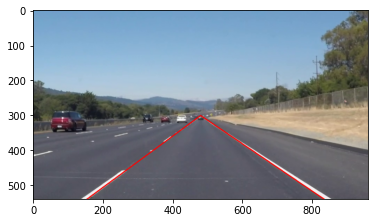

In [30]:
image = get_image()

lane_detector = LaneDetector(
        blur_kernel_size=5,
        region_of_interest=region_of_interest,
        lo_color_threshold=220,
        hi_color_threshold=255,
        lo_canny_threshold=180,
        hi_canny_threshold=240,
        hough_rho=1,
        hough_theta=np.pi/180,
        hough_threshold=10,
        min_line_len=3,
        max_line_gap=5
)

lane = lane_detector.detect(image=image)
draw_lines(image, [lane.left_line, lane.right_line])
plt.imshow(image, cmap='gray')

In [31]:
def calculate_dissimilarity(lane_detector: LaneDetector, dataset: [LaneImage]):
    result = 0

    for lane_image in dataset:
        image, ground_truth_lane = lane_image.image.copy(), lane_image.lane

        detected_lane = lane_detector.detect(image=image)

        result = result + ground_truth_lane.dissimilarity_with(other_lane=detected_lane)
        
    return result
    
lane_detector = LaneDetector(
    blur_kernel_size=5,
    region_of_interest=region_of_interest,
    lo_color_threshold=220,
    hi_color_threshold=255,
    lo_canny_threshold=180,
    hi_canny_threshold=240,
    hough_rho=1,
    hough_theta=np.pi/180,
    hough_threshold=10,
    min_line_len=3,
    max_line_gap=5
)
dissimilarity = calculate_dissimilarity(lane_detector=lane_detector, dataset=train_dataset)
print(dissimilarity)

2.4788555139005237


# Monte Carlo simulation

I obtained best results running 1 million attempts and got 1.96 dissimilarity index which is 20% better than value picked by hands.

To have good enougn results 1000 iterations are Ok.

In [32]:
import random
import tqdm
import multiprocessing
from itertools import repeat

best_dissimilarity = float('+inf')

# put here one million and expect to wait for 80 hours divided by number of cores you have
monte_carlo_run_attempts_count = 1000

lane_detectors = [LaneDetector(
    blur_kernel_size=random.choice([3, 5, 7, 9]),
    region_of_interest=region_of_interest,
    lo_color_threshold=random.randint(180, 239),
    hi_color_threshold=random.randint(240, 255),
    lo_canny_threshold=random.randint(160, 219),
    hi_canny_threshold=random.randint(220, 255),
    hough_rho=1,
    hough_theta=np.pi/180,
    hough_threshold=random.randint(5, 15),
    min_line_len=random.randint(3, 15),
    max_line_gap=random.randint(3, 15)
) for _ in range(monte_carlo_run_attempts_count)]

with multiprocessing.Pool() as pool:
    dissimilarities = pool.starmap(calculate_dissimilarity, zip(lane_detectors, repeat(train_dataset)))
    
best = min(zip(dissimilarities, lane_detectors), key = lambda v: v[0])

best_dissimilarity = best[0]
best_detector = best[1]

print(best_dissimilarity)
print(best_detector)



<ipython-input-1-ca47e8b89b95>:39: RuntimeWarning: invalid value encountered in double_scalars
  intersection_y = self.m * (other_line.b - self.b) / (self.m - other_line.m) + self.b
<ipython-input-1-ca47e8b89b95>:39: RuntimeWarning: invalid value encountered in double_scalars
  intersection_y = self.m * (other_line.b - self.b) / (self.m - other_line.m) + self.b
<ipython-input-1-ca47e8b89b95>:38: RuntimeWarning: divide by zero encountered in double_scalars
  intersection_x = (other_line.b - self.b) / (self.m - other_line.m)
<ipython-input-1-ca47e8b89b95>:39: RuntimeWarning: invalid value encountered in double_scalars
  intersection_y = self.m * (other_line.b - self.b) / (self.m - other_line.m) + self.b
<ipython-input-1-ca47e8b89b95>:38: RuntimeWarning: divide by zero encountered in double_scalars
  intersection_x = (other_line.b - self.b) / (self.m - other_line.m)
<ipython-input-1-ca47e8b89b95>:39: RuntimeWarning: invalid value encountered in double_scalars
  intersection_y = self.m * (

nan

        blur_kernel_size: 9
        region_of_interest: [<__main__.Point object at 0x7f2bc4b8e700>, <__main__.Point object at 0x7f2bc4b8e730>, <__main__.Point object at 0x7f2bc4b8e8b0>, <__main__.Point object at 0x7f2bc4b8e910>]
        lo_color_threshold: 223
        hi_color_threshold: 249
        lo_canny_threshold: 172
        hi_canny_threshold: 243
        hough_rho: 1
        hough_theta: 0.017453292519943295
        hough_threshold: 5
        min_line_len: 13
        max_line_gap: 15



In [33]:
best_dissimilarity=1.9604924359105687
best_detector = LaneDetector(
    blur_kernel_size=3,
    region_of_interest=region_of_interest,
    lo_color_threshold=204,
    hi_color_threshold=249,
    lo_canny_threshold=165,
    hi_canny_threshold=249,
    hough_rho=1,
    hough_theta=np.pi/180,
    hough_threshold=13,
    min_line_len=13,
    max_line_gap=3
)

1.9604924359105687

        blur_kernel_size: 3
        region_of_interest: [<__main__.Point object at 0x7fa01460a790>, <__main__.Point object at 0x7fa01460a850>, <__main__.Point object at 0x7fa01460a730>, <__main__.Point object at 0x7fa01460a8e0>]
        lo_color_threshold: 204
        hi_color_threshold: 249
        lo_canny_threshold: 165
        hi_canny_threshold: 249
        hough_rho: 1
        hough_theta: 0.017453292519943295
        hough_threshold: 13
        min_line_len: 13
        max_line_gap: 3

## Test on images and videos

In [34]:
import os
image_file_names = os.listdir("test_images/")
image_file_names

['solidYellowCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve2.jpg',
 'solidWhiteCurve.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

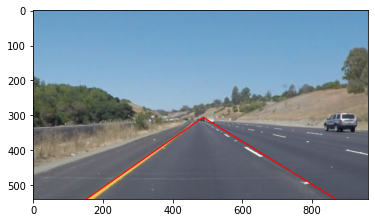

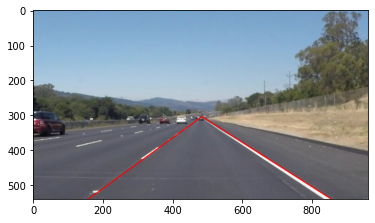

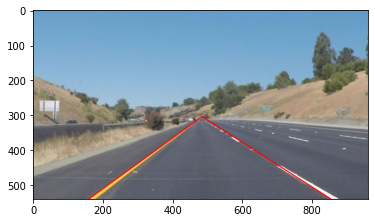

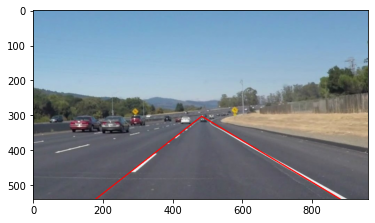

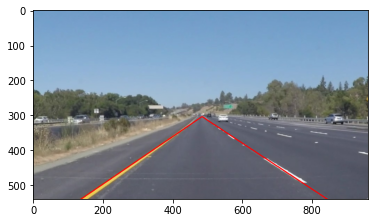

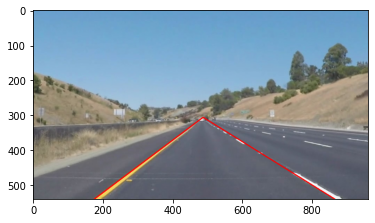

In [47]:
os.makedirs("test_images_output/", exist_ok = True) 

for image_file_name in image_file_names:
    image = np.array(Image.open(os.path.join("test_images", image_file_name)))
    
    lane = best_detector.detect(image=image)
    
    draw_lines(image, [lane.left_line, lane.right_line])
    plt.imshow(image)
    plt.show()
    
    pil_image = Image.fromarray(image)
    pil_image.save(os.path.join("test_images_output", image_file_name))

In [36]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [37]:
import statistics
import math

class AveragerLaneDetector:
    def __init__(self, depth: int, lane_detector: LaneDetector):
        self.depth: int = depth
        self.lane_detector = lane_detector
        self.lane_buffer: [Lane] = []
            
    def flush_lane_buffer(self):
        self.lane_buffer = []

    
    def get_average_line(self, lines: [Line]) -> Line:
        average_m = statistics.mean([line.m for line in lines])
        average_b = statistics.mean([line.b for line in lines])
        
        point_1 = Point(x=0, y=average_m * 0 + average_b)
        point_2 = Point(x=1, y=average_m * 1 + average_b)
        
        return Line(point_1=point_1, point_2=point_2)
    
    def get_average_lane(self, lanes: [Lane]) -> Lane:
        left_lines = [lane.left_line for lane in lanes]
        right_lines = [lane.right_line for lane in lanes]
        
        average_left_line = self.get_average_line(lines=left_lines)
        average_right_line = self.get_average_line(lines=right_lines)
        
        lane = Lane(left_line=average_left_line, right_line=average_right_line)
        
        full_length_left_line = lane.get_full_length_left_line()
        full_length_right_line = lane.get_full_length_right_line()
        return Lane(left_line=full_length_left_line, right_line=full_length_right_line)
    
    def detect(self, image):
        lane = self.lane_detector.detect(image=image)
        
        successfully_detected_lane = not math.isnan(lane.left_line.m) and not math.isnan(lane.right_line.m)
        
        if successfully_detected_lane:
            self.lane_buffer.append(lane)
            
        buffer_length_exceeds_depth = len(self.lane_buffer) > self.depth
        if buffer_length_exceeds_depth:
            self.lane_buffer.pop(0)
            
        return self.get_average_lane(self.lane_buffer)

In [38]:
averager_lane_detector = AveragerLaneDetector(depth=5, lane_detector=best_detector)

def process_image(image):
    lane = averager_lane_detector.detect(image=image)
    
    draw_lines(image, [lane.left_line, lane.right_line])
    
    return image

In [39]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
averager_lane_detector.flush_lane_buffer()
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(white_output, audio=False)

t:   8%|▊         | 18/221 [00:00<00:01, 174.38it/s, now=None]

Moviepy - Building video test_videos_output/solidWhiteRight.mp4.
Moviepy - Writing video test_videos_output/solidWhiteRight.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/solidWhiteRight.mp4
CPU times: user 1.44 s, sys: 701 ms, total: 2.14 s
Wall time: 2.69 s


In [40]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [41]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
averager_lane_detector.flush_lane_buffer()
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

t:   0%|          | 0/681 [00:00<?, ?it/s, now=None]

Moviepy - Building video test_videos_output/solidYellowLeft.mp4.
Moviepy - Writing video test_videos_output/solidYellowLeft.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/solidYellowLeft.mp4
CPU times: user 4.55 s, sys: 1.99 s, total: 6.54 s
Wall time: 7.98 s


In [42]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

In [43]:
challenge_output = 'test_videos_output/challenge.mp4'
clip3 = VideoFileClip('test_videos/challenge.mp4')
averager_lane_detector.flush_lane_buffer()
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

t:   0%|          | 0/251 [00:00<?, ?it/s, now=None]

Moviepy - Building video test_videos_output/challenge.mp4.
Moviepy - Writing video test_videos_output/challenge.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/challenge.mp4
CPU times: user 2.6 s, sys: 1.29 s, total: 3.88 s
Wall time: 6.14 s


In [44]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))